In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from sklearn.model_selection import GridSearchCV
from pickle import dump
from sklearn import tree

In [33]:
data = pd.read_csv('/workspaces/Decision-tree-algorithm/data/processed/clean-data.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0
4,0,137,40,43.1,2.288,33,1


In [34]:
X = data.drop("Outcome", axis = 1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Random Forest

In [35]:
model = RandomForestClassifier(n_estimators=5, max_depth=5, min_samples_leaf=20, max_features=X_train.shape[1]//2, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=20,
                       n_estimators=5, random_state=42)

In [36]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [37]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [38]:
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.792746,0.690722,0.760900,0.736264,0.650485,0.871314
Test,0.827586,0.719101,0.803466,0.695652,0.744186,0.862745
Diferencia,-0.034840,-0.028379,-0.042566,0.040612,-0.093701,0.008569


 - Accuracy (Precisión): El modelo alcanza una precisión del 79.27% en el conjunto de entrenamiento y del 82.76% en el conjunto de prueba. Esto significa que el modelo clasifica correctamente el 79.27% de las muestras en el conjunto de entrenamiento y el 82.76% de las muestras en el conjunto de prueba.

 - F1 Score: El F1-score del modelo es del 69.07% en el conjunto de entrenamiento y del 71.91% en el conjunto de prueba. El F1-score es una medida de precisión que tiene en cuenta tanto la precisión como el recall del modelo. Un F1-score más alto indica un mejor equilibrio entre precisión y recall.

 - AUC (Area Under Curve): El AUC del modelo es del 76.09% en el conjunto de entrenamiento y del 80.35% en el conjunto de prueba. El AUC es una medida de la capacidad del modelo para distinguir entre clases positivas y negativas. Un valor de AUC más alto indica un mejor rendimiento del modelo.

 - Precision (Precisión): La precisión del modelo es del 73.63% en el conjunto de entrenamiento y del 69.56% en el conjunto de prueba. La precisión es la proporción de verdaderos positivos entre todos los casos positivos identificados por el modelo.

 - Recall (Recuperación o Sensibilidad): El recall del modelo es del 65.05% en el conjunto de entrenamiento y del 74.42% en el conjunto de prueba. El recall es la proporción de verdaderos positivos identificados por el modelo entre todos los casos positivos reales en los datos.

 - Specificity (Especificidad): La especificidad del modelo es del 87.13% en el conjunto de entrenamiento y del 86.27% en el conjunto de prueba. La especificidad es la proporción de verdaderos negativos identificados por el modelo entre todos los casos negativos reales en los datos.

En general, el modelo parece tener un rendimiento razonablemente bueno en ambos conjuntos de datos, con poca diferencia entre el rendimiento en el conjunto de entrenamiento y el conjunto de prueba, lo que sugiere que no está sufriendo de sobreajuste. Sin embargo, sería recomendable realizar una evaluación más detallada del modelo para comprender mejor su rendimiento y posiblemente realizar ajustes adicionales si es necesario.

Optimización del modelo RF

In [47]:
hyperparams = {
    "n_estimators": [5, 10, 15, 20],
    "criterion": ["gini", "entropy"],                # Funciones de criterio para medir la calidad de una división
    "max_depth": [2, 5, 10, 15, 20],             # La profundidad máxima del árbol
    "min_samples_leaf": [5, 10, 15, 20],              # Número mínimo de muestras requeridas para ser un nodo hoja
    "max_features": [1, 2, 3, 4, 5, 6]
}

# Búsqueda en cuadrícula con validación cruzada
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)   # métrica de evaluación (scoring - "accuracy" para maximizar la precisión) 
grid                                                                           # nº de divisiones de validación cruzada (cv, que se establece en 10).


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=5,
                                              min_samples_leaf=3,
                                              min_samples_split=10,
                                              n_estimators=5, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 15, 20],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'n_estimators': [5, 10, 15, 20]},
             scoring='accuracy')

In [48]:
grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 5, 'n_estimators': 5}


In [49]:
model = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', max_depth = 5, min_samples_leaf = 5, max_features = 6, random_state = 42)
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features=6,
                       min_samples_leaf=5, n_estimators=5, random_state=42)

In [50]:
m_train_pred = model.predict(X_train)
m_test_pred = model.predict(X_test)
get_metrics(y_train, y_test, m_train_pred, m_test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.83247,0.749354,0.803684,0.801105,0.703883,0.903485
Test,0.82069,0.697674,0.785112,0.697674,0.697674,0.872549
Diferencia,0.01178,0.051680,0.018573,0.103431,0.006209,0.030936


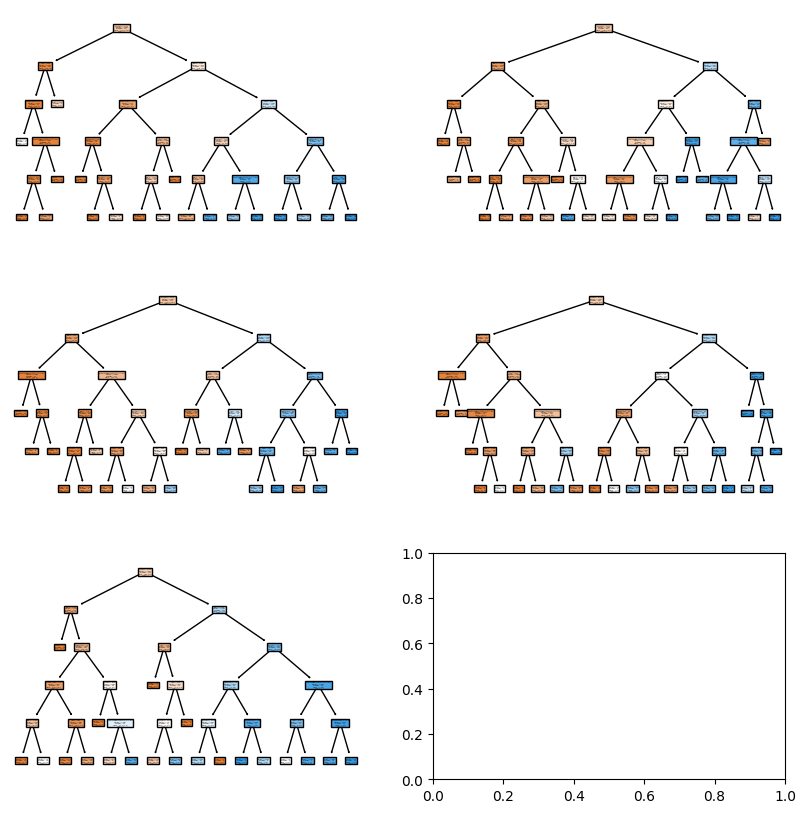

In [52]:

fig, axis = plt.subplots(3, 2, figsize = (10, 10))

# We show the first 4 trees out of the 100 generated (default)
tree.plot_tree(model.estimators_[0], ax = axis[0, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[1], ax = axis[0, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[2], ax = axis[1, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[3], ax = axis[1, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(model.estimators_[4], ax = axis[2, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()


In [ ]:
dump(model, open("../models/ranfor_classifier_nestimators-5_42.sav", "wb"))